In [1]:
import numpy as np
import pandas as pd
import time
from datetime import datetime
import json
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/var/folders/zr/0mklm_6s5zg8kfjw3xy0w3bh0000gn/T/ipykernel_34453/3700585894.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [7]:
import sys
sys.path.append('/Users/tylermartin/Documents/programming/london_weather/london-weather')

In [164]:
from datetime import timedelta
from matplotlib import cm
from matplotlib.colors import Normalize

In [165]:
from make_plots import apply_mdates

In [166]:
TOP_DIR='/Users/tylermartin/Documents/programming/london_weather'

In [167]:
def f_to_c(f):
    return round((f-32)*5/9,2)

In [174]:
files =list(Path(TOP_DIR).glob('data/*.parquet'))
files.sort()

In [175]:
df=pd.concat([pd.read_parquet(f) for f in tqdm(files)])

df['temp_c']=df.temp.apply(f_to_c)
df['date']=df.ts.dt.floor('D')
day=df.groupby('date').temp_c.max().to_frame().reset_index()

  0%|          | 0/1257 [00:00<?, ?it/s]

In [176]:
day

,date,temp_c
0,2019-01-01,10.44
1,2019-01-02,5.87
2,2019-01-03,5.18
3,2019-01-04,3.84
4,2019-01-05,5.87
...,...,...
1252,2022-06-06,16.22
1253,2022-06-07,20.73
1254,2022-06-08,20.93
1255,2022-06-09,19.91


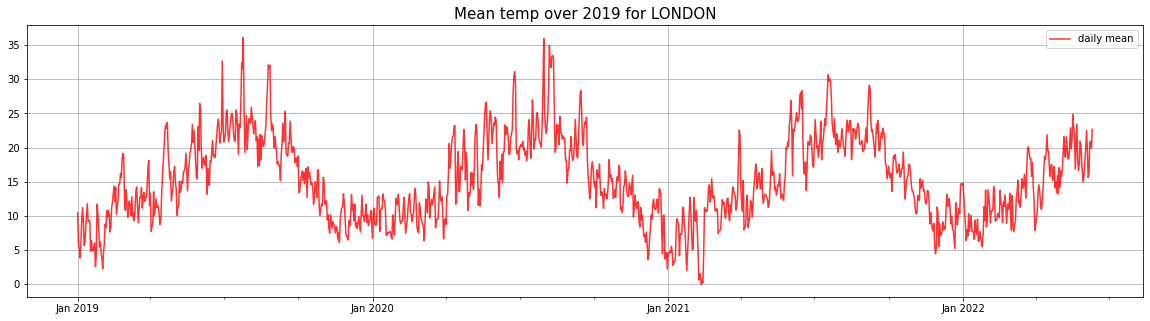

In [177]:
freq='year'
color='red'

_ = plt.plot(day.date, day.temp_c, c=color, alpha=.8, label='daily mean')
fig, ax = plt.gcf(), plt.gca()
ax=apply_mdates(ax,freq)

_ = ax.legend(loc=1)
_ = ax.grid()

name='temp'
place='london'
title_text = f'Mean {name} over 2019 for {place.upper()}'
_ = ax.set_title(title_text, size=15)
fig.set_size_inches(20,5)

In [178]:
day['temp_roll']=day.temp_c.rolling(window=5).mean()

In [179]:
day['year']=day.date.dt.year

In [180]:
m=day.year==2019
day.loc[m,'month']=day.date-timedelta(days=365*19+5)

m=day.year==2020
day.loc[m,'month']=day.date-timedelta(days=365*20+5)

m=day.year==2021
day.loc[m,'month']=day.date-timedelta(days=365*21+5)

m=day.year==2022
day.loc[m,'month']=day.date-timedelta(days=365*22+5)

In [183]:
day.sample(5)

,date,temp_c,temp_roll,year,month
823,2021-04-03,10.66,16.170,2021,2000-04-03
488,2020-05-03,14.53,14.120,2020,2000-05-03
945,2021-08-03,20.95,20.378,2021,2000-08-03
1215,2022-04-30,17.05,14.926,2022,2000-04-30
858,2021-05-08,15.99,13.024,2021,2000-05-08


In [184]:
min_date=pd.to_datetime('2000 05 01')
max_date=pd.to_datetime('2000 09 01')
m=(day.month>min_date)&(day.month<max_date)
day=day[m].copy()

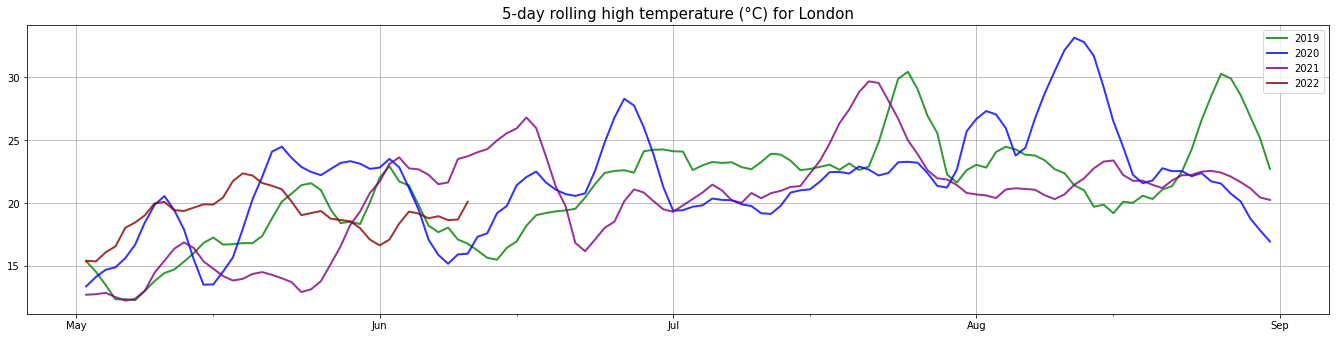

In [212]:
freq='month_no_year'
#colors=['goldenrod','red','darkred','black']
colors=['green','blue','purple','darkred']
lss=['-','--','-.','-']
lss=['-','-','-','-']
plt.figure(facecolor='white')

for year,c,ls in zip(range(2019,2023),colors,lss):
    to_plot=day[day.year==year]
    #_ = plt.plot(to_plot.month, to_plot.temp_c, c=c, alpha=.8, label=year)
    _ = plt.plot(to_plot.month,to_plot.temp_roll,c=c,alpha=.8,ls=ls,label=year,lw=2)

fig, ax = plt.gcf(), plt.gca()
ax=apply_mdates(ax,freq)

_ = ax.legend(loc=1)
_ = ax.grid()

title_text = f'5-day rolling high temperature (°C) for London'
_ = ax.set_title(title_text, size=15)
_=plt.tight_layout()
fig.set_size_inches(20,5)
path=f'{TOP_DIR}/plots/london.png'
plt.savefig(path,dpi=300)

In [188]:
name='Blues'
cmap=plt.get_cmap(name)

In [197]:
cmap = cm.Blues
cmap = cm.plasma
cmap = cm.rainbow
norm = Normalize(vmin=0, vmax=4)
#cmap(norm(1))

colors=[cmap(norm(x)) for x in range(1,5)]

In [198]:
colors

[(0.0019607843137254832, 0.7092813076058534, 0.9232891061054894, 1.0),
 (0.503921568627451, 0.9999810273487268, 0.7049255469061472, 1.0),
 (1.0, 0.7005430375932911, 0.37841105004231035, 1.0),
 (1.0, 1.2246467991473532e-16, 6.123233995736766e-17, 1.0)]